In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os


In [2]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [3]:
DIRECTORY = r"C:\Users/PC/Desktop/VIDYA MASK project/dataset/"
CATEGORIES = ["with_mask", "without_mask"]

In [4]:
print("[INFO] loading images...")


[INFO] loading images...


In [5]:
data = []
labels = []

In [6]:
for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	data.append(image)
    	labels.append(category)


In [7]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [8]:
data = np.array(data, dtype="float32")
labels = np.array(labels)


In [9]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)


In [10]:
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [11]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

In [12]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [13]:
model = Model(inputs=baseModel.input, outputs=headModel)


In [14]:
for layer in baseModel.layers:
	layer.trainable = False


In [15]:
print("Compilation of the MODEL is going on...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])


Compilation of the MODEL is going on...


In [16]:
print("Training Head Started...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

# make predictions on the testing set
print("Network evaluation...")
predIdxs = model.predict(testX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))


Training Head Started...
Epoch 1/20
34/34 [==============================] - 123s 3s/step - loss: 0.6856 - accuracy: 0.6609 - val_loss: 0.2420 - val_accuracy: 0.9710
Epoch 2/20
34/34 [==============================] - 97s 3s/step - loss: 0.2423 - accuracy: 0.9598 - val_loss: 0.1051 - val_accuracy: 0.9891
Epoch 3/20
34/34 [==============================] - 96s 3s/step - loss: 0.1226 - accuracy: 0.9821 - val_loss: 0.0643 - val_accuracy: 0.9891
Epoch 4/20
34/34 [==============================] - 97s 3s/step - loss: 0.0923 - accuracy: 0.9869 - val_loss: 0.0477 - val_accuracy: 0.9891
Epoch 5/20
34/34 [==============================] - 99s 3s/step - loss: 0.0703 - accuracy: 0.9899 - val_loss: 0.0367 - val_accuracy: 0.9928
Epoch 6/20
34/34 [==============================] - 90s 3s/step - loss: 0.0610 - accuracy: 0.9848 - val_loss: 0.0310 - val_accuracy: 0.9928
Epoch 7/20
34/34 [==============================] - 65s 2s/step - loss: 0.0483 - accuracy: 0.9907 - val_loss: 0.0269 - val_accuracy: 0

In [17]:
print("saving mask model...")
model.save("mask_detector.model", save_format="h5")


saving mask model...


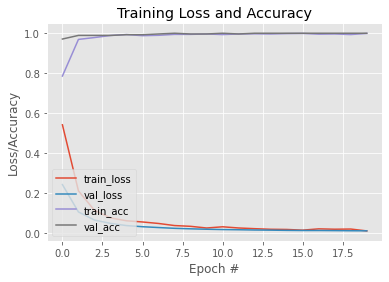

In [18]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")